In [ ]:
#calibration process
import cv2
import numpy as np
def chessboard_pattern(square_size):
    # Parameters
    rows = 13  # number of inner corners along rows
    cols = 8 # number of inner corners along columns    
    # Create a black image
    chessboard = np.zeros((rows * square_size, cols * square_size), dtype=np.uint8)
   
    # Draw the chessboard pattern
    for i in range(rows):
        for j in range(cols):
            if (i + j) % 2 == 0:
                chessboard[i * square_size:(i + 1) * square_size, j * square_size:(j + 1) * square_size] = 255
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # Find corner points in the chessboard pattern
    ret_chessboard, corners_chessboard = cv2.findChessboardCorners(chessboard, (7,12),None)
    
    # If found, add object points, image points (after refining them)
    if ret_chessboard == True:
        corners_pattern_chessboard = cv2.cornerSubPix(chessboard,corners_chessboard,(11,11),(-1,-1),criteria)
        
        # Draw and display the corners
        img_corner = cv2.drawChessboardCorners(chessboard, (7,12), corners_pattern_chessboard,ret_chessboard)
        
        plt.figure()
        plt.imshow(img_corner) 
    return corners_pattern_chessboard
square_len_hsi=40
square_len_rgb=200
corners_pattern_chessboard_hsi = chessboard_pattern(square_len_hsi)
corners_pattern_chessboard_rgb = chessboard_pattern(square_len_rgb)

# Import modules
import numpy as np
import cv2
import glob
import os
import yaml
import matplotlib.pyplot as plt
import time
from skimage.transform import rescale, resize, downscale_local_mean

   
def strench(img):
    nbins = 1000
    tol_low = 0.1
    tol_high = 0.9
    res = np.zeros(img.shape)
    n_bands = 1 if len(img.shape) < 3 else img.shape[2]

    for i in range(n_bands):
        tmp = img if n_bands == 1 else img[:, :, i]
        tmp = tmp - np.min(tmp.ravel())
        tmp = tmp / np.max(tmp.ravel())
        N, _ = np.histogram(tmp.ravel(), nbins)
        cdf = np.cumsum(N)/np.sum(N)  # cumulative distribution function
        ilow = np.where(cdf > tol_low)[0][0]
        ihigh = np.where(cdf >= tol_high)[0][0]
        ilow = (ilow - 1)/(nbins-1)
        ihigh = (ihigh - 1)/(nbins-1)
        li = ilow
        lo = 0
        hi = ihigh
        ho = 255
        out = (tmp < li) * lo
        out = out + np.logical_and(tmp >= li, tmp < hi) * (lo + (ho - lo) * ((tmp - li) / (hi - li)))
        out = out + (tmp >= hi) * ho

        if n_bands == 1:
            res = out
        else:
            res[:, :, i] = out
    return out

# Load calibration images
hsi_board = load_hyperspectral_image('./chessboard/chessboard.raw')
rgb_board_raw = cv2.imread('./chessboard/chessboard.jpg')
rgb_board = rgb_board_raw[:,1000:3000,:]
band_index = 128  # Example band index
hsi_band_raw = hsi_board[:600, :, band_index]
hsi_band = strench(hsi_band_raw).astype(np.uint8)
# Replicate hsi_band to create three identical bands
hsi_band = np.stack([hsi_band] * 3, axis=-1)
_, thresh_hsi = cv2.threshold(hsi_band[:,:,0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, thresh_rgb = cv2.threshold(rgb_board[:,:,0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


# Arrays to store object points and image points from all the images.
imgpoints_hsi = [] # 2d points in image plane.
imgpoints_rgb = [] 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
shape=(7,12)

def calibrate(img,gray,size,imgpoints,sq_len,corners_pattern_chessboard):
    objpoints = [] # 3d point in real world space
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((12*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:12].T.reshape(-1,2)
    objp = objp * sq_len # coordinates of points in mm
    objpoints.append(objp)

    height, width = img.shape[:2]
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, size,None)
    plt.imshow(gray)
    # If found, add object points, image points (after refining them)
    if ret == True:
        imgpoints=[]
        # Refine coordinates of corners at subpixel level
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        img_corners = cv2.drawChessboardCorners(img, size, corners2,ret)
        plt.figure()
        plt.imshow(img_corners)
        plt.show()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    print(ret,'retval is')
    data = {"cmtx": np.asarray(mtx).tolist(),
        "dist": np.asarray(dist).tolist(),
        "corner_pts": np.asarray(imgpoints).tolist()}
    cmtx = np.array(data['cmtx'])
    dist = np.array(data['dist'])
    corner_pts = np.array(data['corner_pts'])
             
    # optimize camera parameters
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(cmtx,dist,(width,height),1,(width,height)) 
    # undistort
    dst = cv2.undistort(img, cmtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    _, gray = cv2.threshold(dst[:,:,0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, size,None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   
    H, mask = cv2.findHomography(corners2, corners_pattern_chessboard, cv2.RANSAC)
    img_rect = cv2.warpPerspective(dst, H, (width, height))
    #rect_corners = 
    # cv2.imshow('img',img)
    plt.figure()
    plt.imshow(img_rect) 
    
    return mtx,dist,newcameramtx,roi,H

def rect(img,mtx,dist,newcameramtx,roi,H):
    # To rectify a new image
    height, width = img.shape[:2]
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    img_rect = cv2.warpPerspective(dst, H, (width, height))
    p,q=img.shape[:2]
    print(img_rect.shape)
    img_rect = img_rect[:p,:q,:]
    # Display or save the rectified image
    plt.figure()
    if img_rect.shape[2]>200:
        plt.imshow(img_rect[:,:,128])
    else:
        plt.imshow(img_rect)
    plt.show()
    return img_rect


mtx,dist,newcameramtx,roi,H=calibrate(hsi_band,thresh_hsi,shape,imgpoints_hsi,square_len_hsi,corners_pattern_chessboard_hsi)

# Assuming mtx, dist, newcameramtx, roi, and H are already defined
# Save the parameters in a .npz file
np.savez('hsi_calibration_parameters.npz', mtx=mtx, dist=dist, newcameramtx=newcameramtx, roi=roi, H=H)


mtx,dist,newcameramtx,roi,H=calibrate(rgb_board,thresh_rgb,shape,imgpoints_rgb,square_len_rgb,corners_pattern_chessboard_rgb)
np.savez('rgb_calibration_parameters.npz', mtx=mtx, dist=dist, newcameramtx=newcameramtx, roi=roi, H=H)

# Load the parameters from the .npz file
data = np.load('hsi_calibration_parameters.npz')

mtx = data['mtx']
dist = data['dist']
newcameramtx = data['newcameramtx']
roi = data['roi']
H = data['H']

img_rect_hsi=rect(hyper_img,mtx,dist,newcameramtx,roi,H)

cropped_img_rect_hsi=img_rect_hsi[:13*square_len_hsi,:8*square_len_hsi]
plt.imshow(cropped_img_rect_hsi[:,:,128])  

data = np.load('rgb_calibration_parameters.npz')
mtx = data['mtx']
dist = data['dist']
newcameramtx = data['newcameramtx']
roi = data['roi']
H = data['H']
img_rect_rgb=rect(rgb_img,mtx,dist,newcameramtx,roi,H)
cropped_img_rect_rgb=img_rect_rgb[:13*square_len_rgb,:8*square_len_rgb]
plt.imshow(cropped_img_rect_rgb)

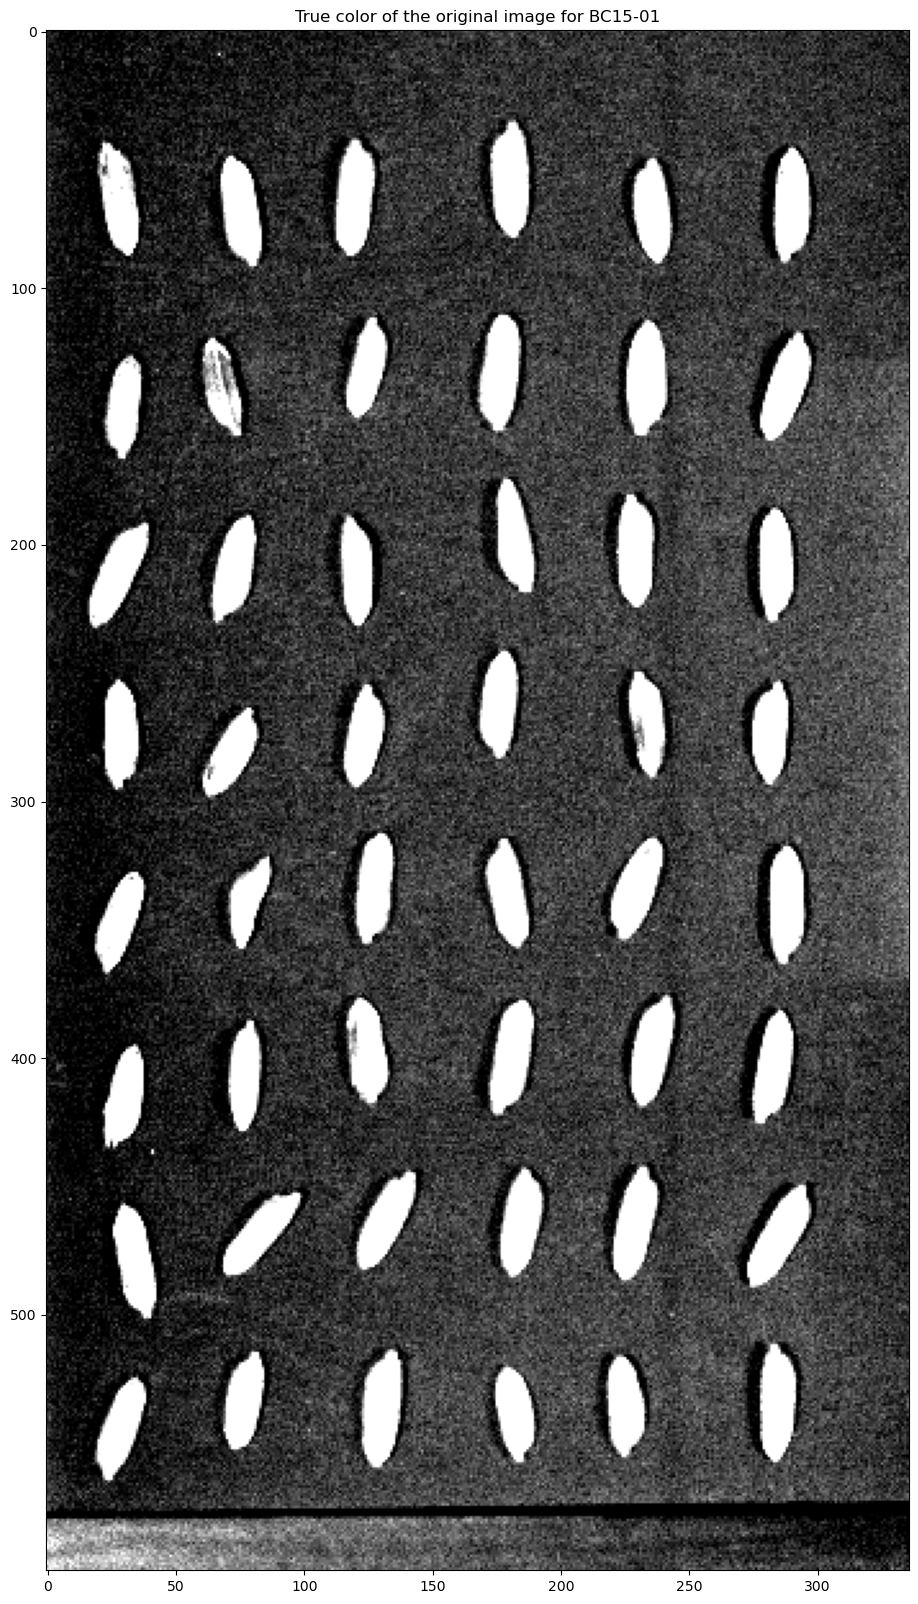

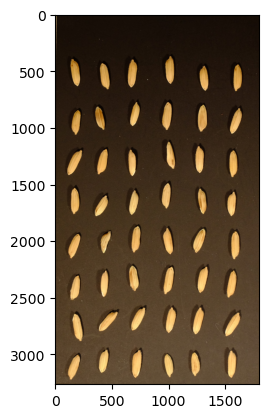

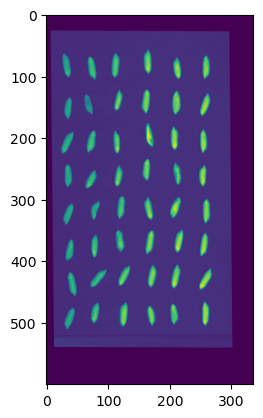

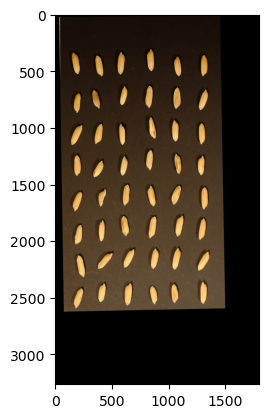

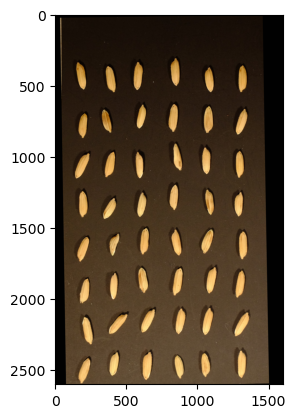

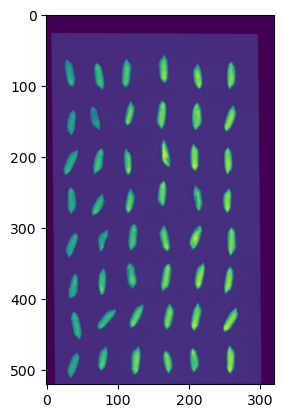

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox
from osgeo import gdal
from skimage.io import imread, imsave, imshow
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
#NepCoTien-01 NepThomBacHai-01 CT286-01 CH12-01
# Define the species variable
species = 'BC15-01'  # Change this variable to handle different rice seed species

# Set the square lengths for HSI and RGB
square_len_hsi = 40
square_len_rgb = 200

def strench(img): 
    # Function to stretch the contrast of the image based on intensity 
    # in this code, 10% of pixels with lowest intensity are set to zero 
    # due to tol_low. Oppsitely 1-0.9 =10% with highest intensity set to 255 
    nbins = 1000
    tol_low = 0.1
    tol_high = 0.9
    res = np.zeros(img.shape)
    n_bands = 1 if len(img.shape) < 3 else img.shape[2]

    for i in range(n_bands):
        tmp = img if n_bands == 1 else img[:, :, i]
        tmp = tmp - np.min(tmp.ravel())
        tmp = tmp / np.max(tmp.ravel())
        N, _ = np.histogram(tmp.ravel(), nbins)
        cdf = np.cumsum(N)/np.sum(N)  # cumulative distribution function
        ilow = np.where(cdf > tol_low)[0][0]
        ihigh = np.where(cdf >= tol_high)[0][0]
        ilow = (ilow - 1)/(nbins-1)
        ihigh = (ihigh - 1)/(nbins-1)
        li = ilow
        lo = 0
        hi = ihigh
        ho = 255
        out = (tmp < li) * lo
        out = out + np.logical_and(tmp >= li, tmp < hi) * (lo + (ho - lo) * ((tmp - li) / (hi - li)))
        out = out + (tmp >= hi) * ho

        if n_bands == 1:
            res = out
        else:
            res[:, :, i] = out
    return out

def show_img(img: np.ndarray, title: str, cmap: str ='gray') -> None:
    """Shows a grayscale or RGB image after performing a stretching of its dynamic."""
    img_stretched = strench(img)
    plt.figure(figsize=(20, 20))
    plt.title(title)
    plt.imshow(img_stretched.astype('uint8'), cmap=cmap)

def load_hyperspectral_image(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        messagebox.showerror("Error", "Failed to open file")
        return None
    bands = dataset.RasterCount
    hyperspectral_image = []
    for i in range(1, bands + 1):
        band = dataset.GetRasterBand(i).ReadAsArray()
        hyperspectral_image.append(band)
    return np.dstack(hyperspectral_image)

def rect(img, mtx, dist, newcameramtx, roi, H):
    """Rectify the given image using calibration parameters."""
    height, width = img.shape[:2]
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    img_rect = cv2.warpPerspective(dst, H, (width, height))
    p, q = img.shape[:2]
    img_rect = img_rect[:p, :q, :]
    plt.figure()
    plt.imshow(img_rect if img_rect.shape[2] <= 200 else img_rect[:, :, 128])
    plt.show()
    return img_rect

# Set working directory based on species
os.chdir(f'F:\\Hanoi project\\RGB and VIS-NIR HSI Data for 90 Rice Seed Varieties')

# Load images based on the species
hyper_img_raw = load_hyperspectral_image(f'./Data-VIS-20170111-1-room-light-off/{species}.raw')
rgb_img_raw = imread(f'./Data-VIS-20170111-1-room-light-off/{species}.jpg')

hyper_img = hyper_img_raw[:600, :, :]
rgb_img = rgb_img_raw[:, 1750:3550, :]

rgb_bands = (101, 61, 33)  # 630nm, 532nm, 465nm
show_img(hyper_img[:, :, rgb_bands], f'True color of the original image for {species}') # show rgb bands of hyperspectral image
plt.show()
plt.imshow(rgb_img)
plt.show()

def find_best_band_by_variance(hyper_img): # find the band with the greatest variablity
    max_variance = 0
    best_band = -1
    
    # Loop through each band in the hyperspectral image
    for i in range(hyper_img.shape[2]):
        # Flatten the band to a 1D array
        flattened_band = hyper_img[:, :, i].flatten()
        
        # Compute variance of the flattened band
        variance = np.var(flattened_band)
        
        # Check if this variance is the largest so far
        if variance > max_variance:
            max_variance = variance
            best_band = i
    
    return best_band

# Example usage
best_band_index = find_best_band_by_variance(hyper_img)

hsi_band_raw = hyper_img[:, :, best_band_index]
hsi_band = strench(hsi_band_raw).astype(np.uint8)
hsi_band = np.stack([hsi_band] * 3, axis=-1)
_, thresh_hsi = cv2.threshold(hsi_band[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, thresh_rgb = cv2.threshold(rgb_img[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Load calibration parameters from .npz files
hsi_calibration_data = np.load(f'hsi_calibration_parameters.npz')
rgb_calibration_data = np.load(f'rgb_calibration_parameters.npz')

# Extract calibration data
mtx_hsi, dist_hsi, newcameramtx_hsi, roi_hsi, H_hsi = (
    hsi_calibration_data['mtx'], hsi_calibration_data['dist'],
    hsi_calibration_data['newcameramtx'], hsi_calibration_data['roi'],
    hsi_calibration_data['H']
)
mtx_rgb, dist_rgb, newcameramtx_rgb, roi_rgb, H_rgb = (
    rgb_calibration_data['mtx'], rgb_calibration_data['dist'],
    rgb_calibration_data['newcameramtx'], rgb_calibration_data['roi'],
    rgb_calibration_data['H']
)

# Rectify images
img_rect_hsi = rect(hyper_img, mtx_hsi, dist_hsi, newcameramtx_hsi, roi_hsi, H_hsi)
img_rect_rgb = rect(rgb_img, mtx_rgb, dist_rgb, newcameramtx_rgb, roi_rgb, H_rgb)

# Crop the images based on the rectified results
cropped_img_rect_hsi = img_rect_hsi[:13 * square_len_hsi, :8 * square_len_hsi]
cropped_img_rect_rgb = img_rect_rgb[:13 * square_len_rgb, :8 * square_len_rgb]

# Function to replace zeros with minimum values for each band
def replace_zero_with_min_bandwise(hsi_img):
    for band in range(hsi_img.shape[2]):
        band_data = hsi_img[:, :, band]
        non_zero_values = band_data[band_data > 0]
        if len(non_zero_values) > 0:
            min_non_zero_value = np.min(non_zero_values)
            band_data[band_data == 0] = min_non_zero_value
        hsi_img[:, :, band] = band_data
    return hsi_img

cropped_img_rect_rgb = replace_zero_with_min_bandwise(cropped_img_rect_rgb)
cropped_img_rect_hsi = replace_zero_with_min_bandwise(cropped_img_rect_hsi)

# Threshold processing
def pre(thresh_rgb, size):
    kernel = np.ones((size, size), np.uint8)
    thresh_rgb = cv2.morphologyEx(thresh_rgb, cv2.MORPH_CLOSE, kernel)
    thresh_rgb = cv2.morphologyEx(thresh_rgb, cv2.MORPH_OPEN, kernel)
    return thresh_rgb

# Apply preprocessing
_, thresh_rgb = cv2.threshold(cropped_img_rect_rgb[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, thresh_hsi = cv2.threshold(cropped_img_rect_hsi[:, :, best_band_index], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
thresh_hsi = pre(thresh_hsi.astype(np.uint8), 3)
thresh_rgb = pre(thresh_rgb, 10)

# Segmentation keypoint detection (same as before)
# (use `find_key_points`, `crop`, and `cropped_images` functions as per your previous script)

# Display final images
plt.imshow(cropped_img_rect_rgb)
plt.show()
plt.imshow(cropped_img_rect_hsi[:, :, best_band_index])
plt.show()
thresh_rgb[:,:120]=255

def find_and_crop_segments(thresh_img, original_img, padding=5):
    """
    Find segments in the thresholded image and crop corresponding areas 
    from the original image with a small padding around each segment.

    Args:
    - thresh_img: Binary thresholded image (0 for rice grains, 255 for background)
    - original_img: Original image to crop from (RGB or HSI)
    - padding: The amount of surrounding area to include around each segment.

    Returns:
    - crops: List of cropped images from the original image.
    """
    # Find contours where pixel value is 0 (grains)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    crops = []
    crops_thresh = []
    for contour in contours:
        # Get the bounding box of each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add padding to the bounding box
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(original_img.shape[1], x + w + padding)
        y_end = min(original_img.shape[0], y + h + padding)
        
        # Crop the original image using the expanded bounding box
        cropped_img = original_img[y_start:y_end, x_start:x_end]
        crops.append(cropped_img)
        cropped_thresh = thresh_img[y_start:y_end, x_start:x_end]
        crops_thresh.append(cropped_thresh)
    return crops,crops_thresh
thresh_hsi[:,280:]=255
# Example usage for RGB and HSI images
thresh_hsi[:,:24]=255
padding = 10  # Adjust padding as needed
croped_rgb, croped_thresh_rgb= find_and_crop_segments(255-thresh_rgb, cropped_img_rect_rgb, padding+10)
croped_hsi, croped_thresh_hsi = find_and_crop_segments(255-thresh_hsi, cropped_img_rect_hsi, padding)

def convert_list_to_uint8(image_list):
    """
    Converts all elements in a list of images to uint8.
    
    Args:
    - image_list: List of 3D images (each image can be of any dtype).
    
    Returns:
    - uint8_list: List of images where each image is converted to uint8.
    """
    # Convert each element of the list to uint8 using list comprehension
    uint8_list = [img.astype(np.uint8) for img in image_list]
    
    return uint8_list

# Example usage:
croped_hsi_uint8 = convert_list_to_uint8(croped_hsi)


In [3]:
from skimage import transform, exposure
from sklearn.decomposition import IncrementalPCA
import numpy as np

def resample_hsi(hsi, target_shape):
    # Resample the downsampled HSI image to match the RGB image's spatial resolution
    hsi_resampled = transform.resize(hsi.astype(np.float32), target_shape, mode='reflect', anti_aliasing=True, preserve_range=True)   
    return hsi_resampled.astype(np.float32)

def perform_incremental_pca(hsi_resampled, n_components, batch_size):
    # Flatten the HSI image for PCA
    hsi_flat = hsi_resampled.reshape(-1, hsi_resampled.shape[2])
   
    # Initialize IncrementalPCA
    ipca = IncrementalPCA(n_components=n_components)
    
    # Perform Incremental PCA in batches to manage memory
    for i in range(0, hsi_flat.shape[0], batch_size):
        batch = hsi_flat[i:i + batch_size]
        ipca.partial_fit(batch)
    
    # Transform the data after fitting
    hsi_pca = ipca.transform(hsi_flat)
    
    # Return PCA results and variance ratio
    return hsi_pca, ipca, hsi_flat, ipca.explained_variance_ratio_

def match_histogram(hsi_pc, rgb_channel):
    # Match the histogram of the first principal component with the RGB channel
    matched_pc = exposure.match_histograms(hsi_pc, rgb_channel.flatten())
    return matched_pc

def reconstruct_hsi_batchwise(hsi_pca, ipca, matched_pc, flat_shape, original_shape, batch_size):
    """Perform inverse PCA transform in batches."""
    # Replace the first principal component with the matched one
    hsi_pca[:, 0] = matched_pc
    
    # Initialize an empty array to store the reconstructed HSI image with 256 bands
    hsi_reconstructed_flat = np.zeros(flat_shape, dtype=np.float32)
    
    # Perform inverse transform in batches
    for i in range(0, hsi_pca.shape[0], batch_size):
        batch_pca = hsi_pca[i:i + batch_size]
        batch_reconstructed = ipca.inverse_transform(batch_pca)  # This returns the full 256 bands
        hsi_reconstructed_flat[i:i + batch_size] = batch_reconstructed
    
    # Reshape the flat array back to the original image shape
    hsi_reconstructed = hsi_reconstructed_flat.reshape(original_shape)
    
    return hsi_reconstructed

def run_reconstruction(rgb, hsi, n_components, batch_size):
    # Step 1: Resample HSI to match RGB resolution with downsampling
    hsi_resampled = resample_hsi(hsi, rgb.shape[:2])
    
    # Step 2: Perform Incremental PCA on the resampled HSI image
    hsi_pca, ipca, hsi_flat, explained_variance_ratio = perform_incremental_pca(hsi_resampled, n_components, batch_size)
    
    # Step 3: Match the first principal component with an RGB channel (e.g., the intensity or a specific channel)
    matched_pc = match_histogram(hsi_pca[:, 0], rgb[:, :, 0])  # Using the red channel for matching
    
    # Step 4: Reconstruct the high-resolution HSI image in batches
    hsi_reconstructed = reconstruct_hsi_batchwise(hsi_pca, ipca, matched_pc, hsi_flat.shape, hsi_resampled.shape, batch_size=batch_size)
    
    # Calculate the percentage of energy explained by the first component
    first_component_energy = explained_variance_ratio[0] * 100
    total_energy = np.sum(explained_variance_ratio) * 100  # Total explained energy by all components
    
    print(f"Percentage of energy explained by the first component: {first_component_energy:.2f}%")
    print(f"Total energy explained by all {n_components} components: {total_energy:.2f}%")
    
    return hsi_reconstructed


batch_size = 520 * 320
n_components = 20
# Example usage:

hsi_reconstructed = run_reconstruction(cropped_img_rect_rgb, cropped_img_rect_hsi, n_components, batch_size)


def translate_thresh_right_down(thresh_img, translation_x, translation_y):
    """
    Translate the zero-value pixels of the thresholded binary image 10 pixels 
    right and 10 pixels down, and set the other pixels to 255.

    Args:
    - thresh_img: Binary thresholded image (0 for rice grains, 255 for background)
    - translation_x: Horizontal translation (default is 10 pixels to the right).
    - translation_y: Vertical translation (default is 10 pixels down).

    Returns:
    - thresh_reconstruct: Translated binary threshold image.
    """
    # Create an empty array filled with 255 (background)
    thresh_reconstruct = np.ones_like(thresh_img) * 255
    
    # Translate zero-value pixels
    rows, cols = thresh_img.shape
    
    for i in range(rows):
        for j in range(cols):
            if thresh_img[i, j] == 0:  # Only translate pixels with value 0
                new_i = i + translation_y
                new_j = j + translation_x
                
                # Ensure the new coordinates are within the bounds of the image
                if new_i < rows and new_j < cols:
                    thresh_reconstruct[new_i, new_j] = 0
    
    return thresh_reconstruct
    
thresh_reconstruct = translate_thresh_right_down(thresh_rgb, -19, -33)

croped_reconstruct, croped_thresh_reconstruct= find_and_crop_segments(255-thresh_reconstruct, hsi_reconstructed, padding+10)


F:\anaconda3\Lib\site-packages\sklearn\decomposition\_incremental_pca.py:352: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)


Percentage of energy explained by the first component: 97.92%
Total energy explained by all 20 components: 99.99%


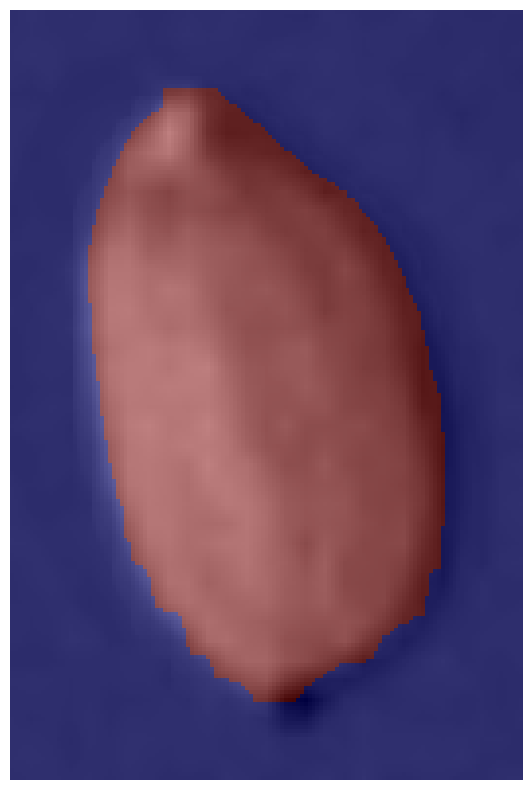

In [5]:
def plot_images_with_transparency(float_img, int_img, alpha=0.5):  # check if the reconstructed image perfectly aligned with its thresh 
    """Plot float32 and int8 images on the same figure with transparency."""
    
    # Normalize the int8 image for display
    int_img_normalized = int_img / np.max(int_img)  # Normalize between 0 and 1

    # Plotting the images
    plt.figure(figsize=(10, 10))

    # Display the float32 image
    plt.imshow(float_img, cmap='gray', alpha=1.0)  # Full intensity for the float image

    # Overlay the int8 image with transparency
    plt.imshow(int_img_normalized, cmap='jet', alpha=alpha)  # Apply transparency (alpha)

    # Show the plot
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Example usage
# float_img: Your float32 image
# int_img: Your int8 image
plot_images_with_transparency(croped_reconstruct[11][:,:,128], croped_thresh_reconstruct[11], alpha=0.5)